## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()
(df[df['landing_page']=='old_page']['user_id']).size

147239

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
type(df['group'][1])
type(df['landing_page'][1])

str

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
# df[df['converted']==1]['user_id'].nunique()
df1 = np.array(df[df['converted']==1]['user_id'].nunique())
df1/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
(df[(df['group']=='control') & (df['landing_page'] !='old_page')]['user_id'].nunique())+(df[(df['group']=='treatment') & (df['landing_page']!='new_page')]['user_id'].count())


3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df

In [10]:
df2 = df2[((df['group']=='treatment')&(df['landing_page']=='new_page'))|((df['group']=='control')&(df['landing_page']=='old_page'))]

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
print(df2['user_id'].count())
df2['user_id'].nunique()

290585


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2bool = df2.duplicated(subset=['user_id'],keep='first')
df2.loc[df2bool==True]
df2[df2.duplicated(subset=['user_id'],keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2.loc[df2['user_id']==773192].index[1]

2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates(subset=['user_id'],keep='first',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
#df2.drop(df2.loc[df2['user_id']==773192].index[1])
df2.count()

user_id         290584
timestamp       290584
group           290584
landing_page    290584
converted       290584
dtype: int64

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2[df2['landing_page'] =='new_page']['user_id'].count())/df2['user_id'].count()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:** No there isnt sufficient evidence considering the results to conclude that treatment page leads to more convertions. We can see that 50% of individuals were given new page and yet the convertion rate is mere 11%. Even the difference between converstion rates of control and treatment group is not significant enough. Hence we cant conclude the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer: $H_{0}: P_{new}  -  P_{old} <= 0.05$**<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**$H_{1}: P_{new}  -  P_{old} > 0.05$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
new_mean = df2['converted'].mean()

In [22]:
new_mean

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
old_mean = df2['converted'].mean()

In [24]:
old_mean

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
newn = sum(df2['landing_page']=='new_page')
newn

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
oldn = sum(df2['landing_page']=='old_page')
oldn

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.binomial(newn, new_mean)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(oldn, old_mean)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# from e old_mean = old_page_converted/oldn
# and f new_mean = new_page_converted/newn
p_diff = (new_page_converted/newn) - (old_page_converted/oldn)
p_diff

6.66279328072894e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs =[]
for _ in range(10000):
    new_page_converted = np.random.binomial(newn, new_mean)
    new_page_converted = np.random.binomial(newn, new_mean)
    p_diffs.append((new_page_converted/newn) - (old_page_converted/oldn))
p_diffs

[-0.0008004837594368791,
 -0.0015230768363070218,
 -0.0007867200817822106,
 -0.0009862934077749103,
 -0.00018800010380409793,
 0.0006997571049220802,
 0.00038319251886467787,
 -0.0006628469828901806,
 -9.165436022140483e-05,
 0.00041760171300135596,
 -0.0013235035103143084,
 1.1573222188615562e-05,
 0.00018361919287197825,
 0.0006102932001667283,
 -0.002562234499234553,
 -0.0002292911367681033,
 -0.002376424850896522,
 -0.0017639411952637268,
 0.0003969561965193602,
 -0.00044950997924281255,
 -0.0015712497080983545,
 -4.348148843005828e-05,
 -0.002871917246464614,
 0.0014154683429648818,
 -0.0013097398326596399,
 -0.0008968295030195583,
 -0.0005114465286888276,
 -0.0014749039645156753,
 0.0013741773100008764,
 -0.0003049913638687868,
 -0.00024993665325009906,
 -0.00015359090966741984,
 0.00014920999873530016,
 -0.0014198492538970015,
 -0.00017423642614942947,
 -0.00014670907084007867,
 0.0002593194199726617,
 -0.0005940285946168383,
 -0.00173641383995439,
 0.00032125596941867673,
 -0.0

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

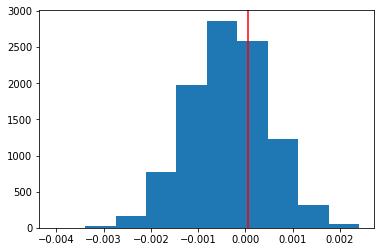

In [31]:
plt.hist(p_diffs);
plt.axvline(x=p_diff, color="red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
#difference in df2
diff_df2 = df2[df2['group']=='treatment']['converted'].mean() - df2[df2['group']=='control']['converted'] .mean()
diff_df2

-0.0015782389853555567

In [33]:
(p_diffs > diff_df2).mean()

0.92769999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** Since a large prportion of p_diffs are greater than the actual difference observed in ab_data csv. Also, We know that if p value is less than Type 1 error rate , we can reject the Null hypothesis. Since here null hypothesis is much greater than alpha value(0.05) at 0.97, it is significant and hence we fail to reject the null hypothesis. Null hypothesis which states that P(new) <= P(old) is true. Hence we can conclude that there is not much difference between new and old pages.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2[df2['group']=='control']['converted'].sum()
convert_new = df2[df2['group']=='treatment']['converted'].sum()
n_old = (df2.landing_page=='old_page').sum()
n_new = (df2.group=='treatment').sum()
print(convert_old, convert_new, n_old, n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative ='smaller')
stat, pval

(-1.3109241984234394, 0.094941687240975514)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**: A result of -1.31 suggests that the ztest is significant with 96% accuracy, negative value corresponds to values which are smaller than mean. Hence 96% of conversion for treatment group is less than of controlled. 
P value is also 95% with means that we fail to reject the null hypothesis.
Yes they agree with findings in **j and k.** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer.** 
We should perform Logistic regression because:
- this data has variables which are not directly affecting the output but are dependent on eachh other
- it has two possible outcomes ie conversion or no conversion. So the probability can only be between 0 and 1
- we have categorical depend variable, convert.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2[['old_page','new_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = df2['treatment']
df2['intercept'] = 1

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        10:41:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**Answer.** P-value associated with ab_page is 0.19.
Yes the p-values associated with ab_page in Part III differs from p value in Part II which was 0.97. This is  because A/B test is uni-directional test ie, one tailed whereas the regression testing is two-tailed test and doesnt specify the direction. Hence p -value is of bi-direction and to consider a single side, the result should be divided by 2 and subtracted by 1 ie, 1 -(0.19/2) = 0.905. This value seems comparable to the p-value obtained in A/B test.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer.** Yes there are other variables that might affect that conversion. But the rule to limiting number of variables is that if variables do not contribute very much to the variance in the dependent variable (total R2), it can be eliminated. As seen here, variable 'new_page' doesnt change the R-squared value and hence it can be eliminated. 
Having too many variables in model can lead to multicollinearity which leads to unstable results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns 
- Provide the statistical output as well as a written response to answer this question.

In [39]:
dfc = pd.read_csv('countries.csv')
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
df3 = df2.merge(dfc, on ='user_id', how ='inner')
df3.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,old_page,new_page,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,0,1,US


In [41]:
df3[['US','UK','CA']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,old_page,new_page,ab_page,intercept,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,0,1,US,0,0,1


In [42]:
lm1 = sm.Logit(df3['converted'],df3[['intercept','ab_page', 'US','UK']])
res1 = lm1.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [43]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        10:41:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [44]:
np.exp(-0.0408), np.exp(0.0099)

(0.96002111497165088, 1.0099491671175422)

In [45]:
1/np.exp(-0.0149) 

1.0150115583846535

**Answer** : Looking at the p values of the variables , since they are all smaller than 0.05 , we can say that none of them are significant. Hence we fail to reject the null hypothesis. And can conclude that old page is better than new page.
Looking at the coefficient of the variables, we can say that:
- A person from Uk has 1.01 probabilty of converting than other countries keeping all other variables constant 
- Similarly a person from US has 0.96 chances of converting than other countries keeping all other variables constant 
- and for every 1 unit decrease in new page, conversion is 1.015 more likely.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
dfcorr = df3[['converted','ab_page', 'US','UK']]
dfcorr['USPage'] = dfcorr['ab_page'] * dfcorr['US']
dfcorr['UKPage']  = dfcorr['ab_page'] * dfcorr['UK']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
dfcorr.corr(method='spearman')

,converted,ab_page,US,UK,USPage,UKPage
converted,1.000000,-0.002432,-0.003022,0.001772,-0.003807,0.001827
ab_page,-0.002432,1.000000,0.001600,-0.002092,0.160519,0.376626
US,-0.003022,0.001600,1.000000,-0.132090,0.700541,-0.086320
UK,0.001772,-0.002092,-0.132090,1.000000,-0.092534,0.653496
USPage,-0.003807,0.160519,0.700541,-0.092534,1.000000,-0.060471
UKPage,0.001827,0.376626,-0.086320,0.653496,-0.060471,1.000000


Looking at all the results, it is clear that old page is better than the new page as it is leads to more conversions than new page.

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

Resources:
- https://web.csulb.edu/~msaintg/ppa696/696regmx.htm
- http://www.real-statistics.com/multiple-regression/multiple-regression-    analysis/multiple-regression-basic-concepts/
- Khan Academy
- StackOverflow and StackExchange
